In [1]:
import sys

from PyMPDATA_examples.Arabas_and_Farhat_2020.options import OPTIONS

if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [1]:
import os
import numpy as np
from scipy.interpolate import make_interp_spline
from matplotlib import pyplot, colors, colormaps, patches
from open_atmos_jupyter_utils import show_plot
# from PyMPDATA_examples.Magnuszewski_et_al_2025.common import OPTIONS
from PyMPDATA import Options

from PyMPDATA_examples.Magnuszewski_et_al_2025.asian_option import AsianArithmetic, Settings
from PyMPDATA_examples.Magnuszewski_et_al_2025.monte_carlo import BSModel, FixedStrikeArithmeticAsianOption
from PyMPDATA_examples.utils.financial_formulae import Black_Scholes_1973
import PyMPDATA_examples.utils.financial_formulae.asian_option as asian_analytic
from tqdm import tqdm
from PyMPDATA_examples.Magnuszewski_et_al_2025.monte_carlo import BSModel, FixedStrikeArithmeticAsianOption

In [61]:
# base_nx = 21
# base_ny = 31

mc_n_paths = 1000000
mc_seed = 42
mc_path_points = 10000

spot=100



SETTINGS = Settings(
    T=1,
    K=100,
    r=.08,
    sgma=.4,
    S_max=200,
    S_min=50,
)
variant = "call"

OPTIONS_mpdata = Options(
        n_iters=2,
        nonoscillatory=True,
        non_zero_mu_coeff=True,
    )

OPTIONS_upwind = Options(
        n_iters=1,
        non_zero_mu_coeff=True,
    )


In [62]:
mc_model = BSModel(
        T=1,
        sigma=0.4,
        r=0.08,
        M=mc_path_points,
        S0=spot,
        seed=mc_seed
    )
arithmetic_option = FixedStrikeArithmeticAsianOption(1, 100, variant, mc_model, mc_n_paths)
price_by_mc = arithmetic_option.price_by_mc()

In [63]:
price_by_mc

10.71657159283859

In [46]:
scales = [1, 2, 3, 4, 5, 6, 7, 8]

In [47]:
resolution_1 = {
    'nt': 2000,
    'nx': 10,
    'ny': 10,
}
results_1 = {"MPDATA": {},
             "UPWIND": {}}
for scale in scales:
    resolution_scaled = {k: v * scale + 1 for k, v in resolution_1.items()}
    simulation_mpdata = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_mpdata, variant=variant)
    simulation_mpdata.step(simulation_mpdata.nt)
    simulation_price_mpdata = simulation_mpdata.solver.advectee.get()[:, 0]
    
    simulation_upwind = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_upwind, variant=variant)
    simulation_upwind.step(simulation_upwind.nt)
    simulation_price_upwind = simulation_upwind.solver.advectee.get()[:, 0]
    
    results_1["MPDATA"][scale] = np.interp(spot, simulation_mpdata.S, simulation_price_mpdata)
    results_1["UPWIND"][scale] = np.interp(spot, simulation_upwind.S, simulation_price_upwind)

print(results_1)
errors_1 = {
    "MPDATA": [abs(results_1["MPDATA"][scale] - price_by_mc) for scale in scales],
    "UPWIND": [abs(results_1["UPWIND"][scale] - price_by_mc) for scale in scales]
}


courant_number_x=5.503137734564608e-20
cfl_condition=0.00499750124937531
courant_number_x=5.503137734564608e-20
cfl_condition=0.00499750124937531
courant_number_x=5.254308030813647e-20
cfl_condition=0.004998750312421893
courant_number_x=5.254308030813647e-20
cfl_condition=0.004998750312421893
courant_number_x=5.171337153092322e-20
cfl_condition=0.004999166805532409
courant_number_x=5.171337153092322e-20
cfl_condition=0.004999166805532409
courant_number_x=5.12984652919993e-20
cfl_condition=0.0049993750781152325
courant_number_x=5.12984652919993e-20
cfl_condition=0.0049993750781152325
courant_number_x=5.104950495405486e-20
cfl_condition=0.004999500049994999
courant_number_x=5.104950495405486e-20
cfl_condition=0.004999500049994999
courant_number_x=5.0883524480436536e-20
cfl_condition=0.0049995833680526605
courant_number_x=5.0883524480436536e-20
cfl_condition=0.0049995833680526605
courant_number_x=5.076496361216592e-20
cfl_condition=0.004999642882651237
courant_number_x=5.076496361216592e-

In [48]:
resolution_2 = {
    'nt': 2000,
    'nx': 10,
    'ny': 20,
}
results_2 = {"MPDATA": {},
             "UPWIND": {}}
for scale in scales:
    resolution_scaled = {k: v * scale + 1 for k, v in resolution_2.items()}
    simulation_mpdata = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_mpdata, variant=variant)
    simulation_mpdata.step(simulation_mpdata.nt)
    simulation_price_mpdata = simulation_mpdata.solver.advectee.get()[:, 0]
    
    simulation_upwind = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_upwind, variant=variant)
    simulation_upwind.step(simulation_upwind.nt)
    simulation_price_upwind = simulation_upwind.solver.advectee.get()[:, 0]
    
    results_2["MPDATA"][scale] = np.interp(spot, simulation_mpdata.S, simulation_price_mpdata)
    results_2["UPWIND"][scale] = np.interp(spot, simulation_upwind.S, simulation_price_upwind)

print(results_2)
errors_2 = {
    "MPDATA": [abs(results_2["MPDATA"][scale] - price_by_mc) for scale in scales],
    "UPWIND": [abs(results_2["UPWIND"][scale] - price_by_mc) for scale in scales]
}


courant_number_x=5.503137734564608e-20
cfl_condition=0.00999500249875062
courant_number_x=5.503137734564608e-20
cfl_condition=0.00999500249875062
courant_number_x=5.254308030813647e-20
cfl_condition=0.009997500624843786
courant_number_x=5.254308030813647e-20
cfl_condition=0.009997500624843786
courant_number_x=5.171337153092322e-20
cfl_condition=0.009998333611064818
courant_number_x=5.171337153092322e-20
cfl_condition=0.009998333611064818
courant_number_x=5.12984652919993e-20
cfl_condition=0.009998750156230465
courant_number_x=5.12984652919993e-20
cfl_condition=0.009998750156230465
courant_number_x=5.104950495405486e-20
cfl_condition=0.009999000099989998
courant_number_x=5.104950495405486e-20
cfl_condition=0.009999000099989998
courant_number_x=5.0883524480436536e-20
cfl_condition=0.009999166736105321
courant_number_x=5.0883524480436536e-20
cfl_condition=0.009999166736105321
courant_number_x=5.076496361216592e-20
cfl_condition=0.009999285765302474
courant_number_x=5.076496361216592e-20
c

In [49]:
resolution_3 = {
    'nt': 2000,
    'nx': 10,
    'ny': 5,
}
results_3 = {"MPDATA": {},
             "UPWIND": {}}
for scale in scales:
    resolution_scaled = {k: v * scale + 1 for k, v in resolution_3.items()}
    simulation_mpdata = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_mpdata, variant=variant)
    simulation_mpdata.step(simulation_mpdata.nt)
    simulation_price_mpdata = simulation_mpdata.solver.advectee.get()[:, 0]
    
    simulation_upwind = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_upwind, variant=variant)
    simulation_upwind.step(simulation_upwind.nt)
    simulation_price_upwind = simulation_upwind.solver.advectee.get()[:, 0]
    
    results_3["MPDATA"][scale] = np.interp(spot, simulation_mpdata.S, simulation_price_mpdata)
    results_3["UPWIND"][scale] = np.interp(spot, simulation_upwind.S, simulation_price_upwind)

print(results_3)
errors_3 = {
    "MPDATA": [abs(results_3["MPDATA"][scale] - price_by_mc) for scale in scales],
    "UPWIND": [abs(results_3["UPWIND"][scale] - price_by_mc) for scale in scales]
}


courant_number_x=5.503137734564608e-20
cfl_condition=0.002498750624687655
courant_number_x=5.503137734564608e-20
cfl_condition=0.002498750624687655
courant_number_x=5.254308030813647e-20
cfl_condition=0.0024993751562109464
courant_number_x=5.254308030813647e-20
cfl_condition=0.0024993751562109464
courant_number_x=5.171337153092322e-20
cfl_condition=0.0024995834027662046
courant_number_x=5.171337153092322e-20
cfl_condition=0.0024995834027662046
courant_number_x=5.12984652919993e-20
cfl_condition=0.0024996875390576163
courant_number_x=5.12984652919993e-20
cfl_condition=0.0024996875390576163
courant_number_x=5.104950495405486e-20
cfl_condition=0.0024997500249974995
courant_number_x=5.104950495405486e-20
cfl_condition=0.0024997500249974995
courant_number_x=5.0883524480436536e-20
cfl_condition=0.0024997916840263303
courant_number_x=5.0883524480436536e-20
cfl_condition=0.0024997916840263303
courant_number_x=5.076496361216592e-20
cfl_condition=0.0024998214413256186
courant_number_x=5.07649636

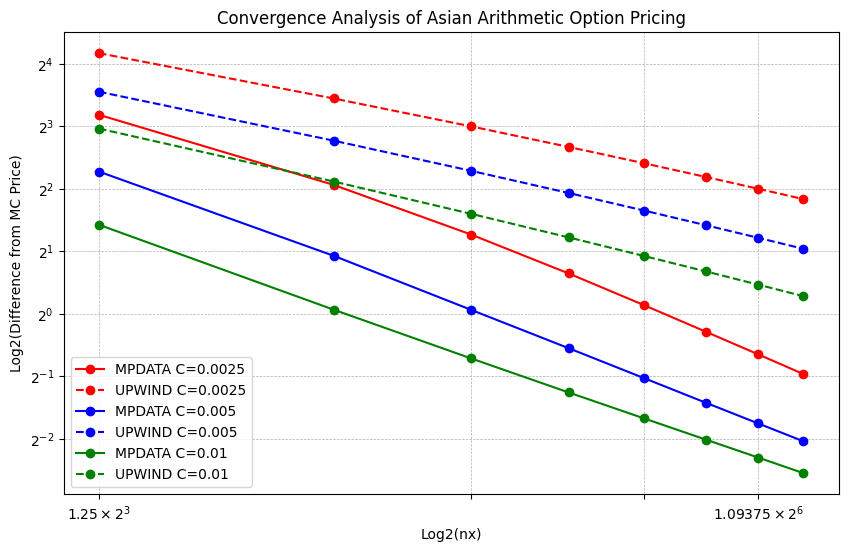

In [60]:
# plot diffs in log2 by log2
fig, ax = pyplot.subplots(figsize=(10, 6))
ax.set_title('Convergence Analysis of Asian Arithmetic Option Pricing')
ax.set_xlabel('Log2(nx)')
ax.set_ylabel('Log2(Difference from MC Price)')
ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.plot([10*x for x in scales], errors_3["MPDATA"], marker='o', linestyle='-', color='r', label='MPDATA C=0.0025')
ax.plot([10*x for x in scales], errors_3["UPWIND"], marker='o', linestyle='--', color='r', label='UPWIND C=0.0025')
ax.plot([10*x for x in scales], errors_1["MPDATA"], marker='o', linestyle='-', color='b', label='MPDATA C=0.005')
ax.plot([10*x for x in scales], errors_1["UPWIND"], marker='o', linestyle='--', color='b', label='UPWIND C=0.005')
ax.plot([10*x for x in scales], errors_2["MPDATA"], marker='o', linestyle='-', color='g', label='MPDATA C=0.01')
ax.plot([10*x for x in scales], errors_2["UPWIND"], marker='o', linestyle='--', color='g', label='UPWIND C=0.01')
# ax.set_xticks([10*x for x in scales])
ax.set_xticks([10*x for x in scales[::2]])
ax.legend()
